#### Author
Yury Kashnitsky

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=74fb1698b3ee449297edbf2d8d984fee)

#### Idea
Run adversarial validation with Tf-Idf & logreg model to detect and visualize data drift. 
#### Data
- 4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view?usp=sharing) (not to be shared outside of the project!)
- `../data/20220530_rss_feed_2022_onwards.csv` – 875 records from the latest 2022 RSS feed

#### Result
- Adversarial validation reveals a data drift, it's very easy for the model to distinguish train data from the new unlabeled data
- Features that drifted most are shown with eli5

In [1]:
from adversarial_data_drift_utils.dataset import prepare_data_for_adv_validation
from adversarial_data_drift_utils.utils import get_notebooks_root, load_adv_validation_params, plot_cv_results, show_weights
from adversarial_data_drift_utils.model import initialize_model, run_cross_validation, train_model
%config InlineBackend.figure_format = 'retina' # sharper plots

## Prepare the data for adversarial validation

The label is binary – whether the record comes from an old dataset (0 for the training set) a new dataset (1 for fresh parsed RSS feeds from 2022). 

In [2]:
advers_val_params = load_adv_validation_params()

In [3]:
df = prepare_data_for_adv_validation(
    path_to_old_data=advers_val_params["data"]["path_to_old_data"],
    path_to_new_data=advers_val_params["data"]["path_to_new_data"],
    text_col_name=advers_val_params["data"]["text_col_name"],
    label_col_name=advers_val_params["data"]["label_col_name"],)

In [4]:
df.head()

,title,is_new
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,0
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,0
2,Thinking of Travelling With Bitcoin? With Thes...,0
3,Investors Carried Out Mental Gymnastics to Jus...,0
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",0


In [5]:
df['is_new'].value_counts()

0    4554
1     875
Name: is_new, dtype: int64

## Model


In [6]:
model = initialize_model(model_params=advers_val_params["model"])

In [7]:
model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg',
                 LogisticRegression(C=1, max_iter=500, n_jobs=4,
                                    random_state=17))])

## Running cross-validation

Run repeated cross-validation with params defined in the `adversarial_data_drift_utils/config.yml` file

In [8]:
%%time
cv_results = run_cross_validation(
    model_params=advers_val_params["model"],
    cross_val_params=advers_val_params["cross_validation"],
    train_texts=df[advers_val_params["data"]["text_col_name"]],
    train_targets=df[advers_val_params["data"]["label_col_name"]]
)

CPU times: user 529 ms, sys: 110 ms, total: 640 ms
Wall time: 20.1 s


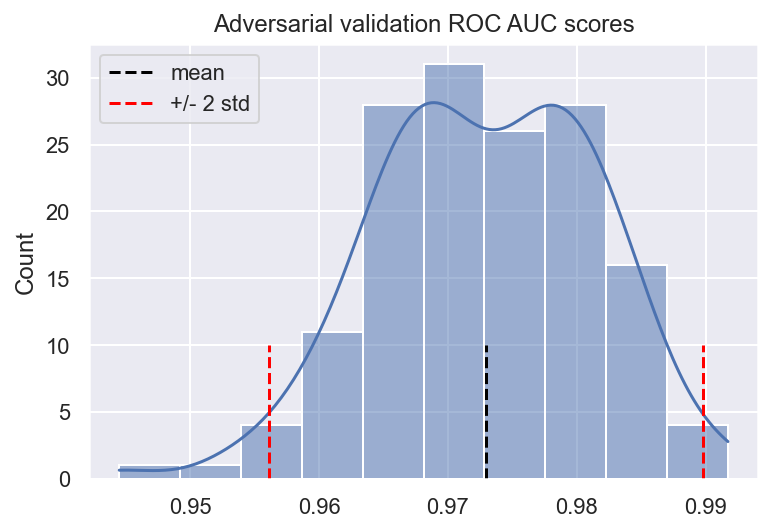

In [9]:
plot_cv_results(cv_results);

**In this case, it's very easy for the model to distinguish train data from the new unlabeled data**

## Feature importance

Which features (words/bigrams) drifted the most?

In [10]:
model = train_model(
    model_params=advers_val_params["model"],
    train_texts=df[advers_val_params["data"]["text_col_name"]],
    train_targets=df[advers_val_params["data"]["label_col_name"]]
)

**Findings:**
- most characteristic features for the train set: obviously, years (2017, 2018)
- most characteristic features for the eval set: obviously, years (2021, 2022) but also NFT, metaverse, web3, etc. Interestingly, there's also oil and cannabis.

In [12]:
show_weights(model=model, n_top=30)

Weight?,Feature
+4.262,news
+3.899,stock news
+3.873,stock
+3.324,crypto
+3.136,2022
+3.068,podcast
+2.657,nft
+2.402,tsxv
+2.311,terra
+2.199,nyse
